In [ ]:
# pip install matplotlib

In [ ]:
# pip install nltk

In [ ]:
pip install shap

In [ ]:
# pip install scikit-learn

In [ ]:
# pip install numpy==1.23

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import re
import nltk
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
df = pd.read_csv("./realdonaldtrump.csv")
df.head(5)

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [ ]:
df = df.drop(["id","link"], axis = 1)
df.describe()

,retweets,favorites
count,43352.000000,43352.000000
mean,6264.766908,26234.241788
std,11120.363335,47705.445640
min,0.000000,0.000000
25%,27.000000,30.000000
50%,396.500000,369.000000
75%,10753.000000,45784.000000
max,302269.000000,835575.000000


In [ ]:
label = 'content'
df = df.drop_duplicates(subset=[label])
df[label] = df[label].str.lower()
df[label] = df[label].apply(lambda x: x.replace("\n", " "))
df[label] = df[label].apply(lambda x: x.replace("\r", " "))
df[label] = df[label].apply(lambda x: x.replace("\t", " "))
df[label] = df[label].apply(lambda x: re.sub(r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])""", " ", x))
df[label] = df[label].apply(lambda x: x.replace("@ ", "@"))
df[label] = df[label].apply(lambda x: re.sub(r"@([a-zA-Z0-9_.-]{1,100})", " ", x))
df[label] = df[label].apply(lambda x: re.sub(r"http\S+", " ", x))
df[label] = df[label].apply(lambda x: re.sub(r"#\w+", " ", x))
df[label] = df[label].apply(lambda x: re.sub(r"\d+", " ", x))
df[label] = df[label].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [ ]:
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text
df['content']=df['content'].apply(lambda x: remove_stopword(x))

In [ ]:
def comp_dict(score):
    if score > 0.0:
        return 'pos'
    return 'neg'

In [ ]:
sentiment = SentimentIntensityAnalyzer()

df["polarity"] = df["content"].apply(lambda x: sentiment.polarity_scores(x))
df["compound"] = df["polarity"].apply(lambda x: x["compound"])
df['sentiment'] = df['compound'].apply(comp_dict)

In [ ]:
df.head(5)

,content,date,retweets,favorites,mentions,hashtags,polarity,compound,sentiment
0,sure tune watch donald trump late night david ...,2009-05-04 13:54:25,510,917,NaN,NaN,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.4767,pos
1,donald trump appearing view tomorrow morning d...,2009-05-04 20:00:10,34,267,NaN,NaN,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'comp...",0.7506,pos
2,donald trump reads top ten financial tips late...,2009-05-08 08:38:08,13,19,NaN,NaN,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...",0.5719,pos
3,new blog post celebrity apprentice finale less...,2009-05-08 15:40:15,11,26,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neg
4,persona never wallflower rather build walls cl...,2009-05-12 09:07:28,1375,1945,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neg


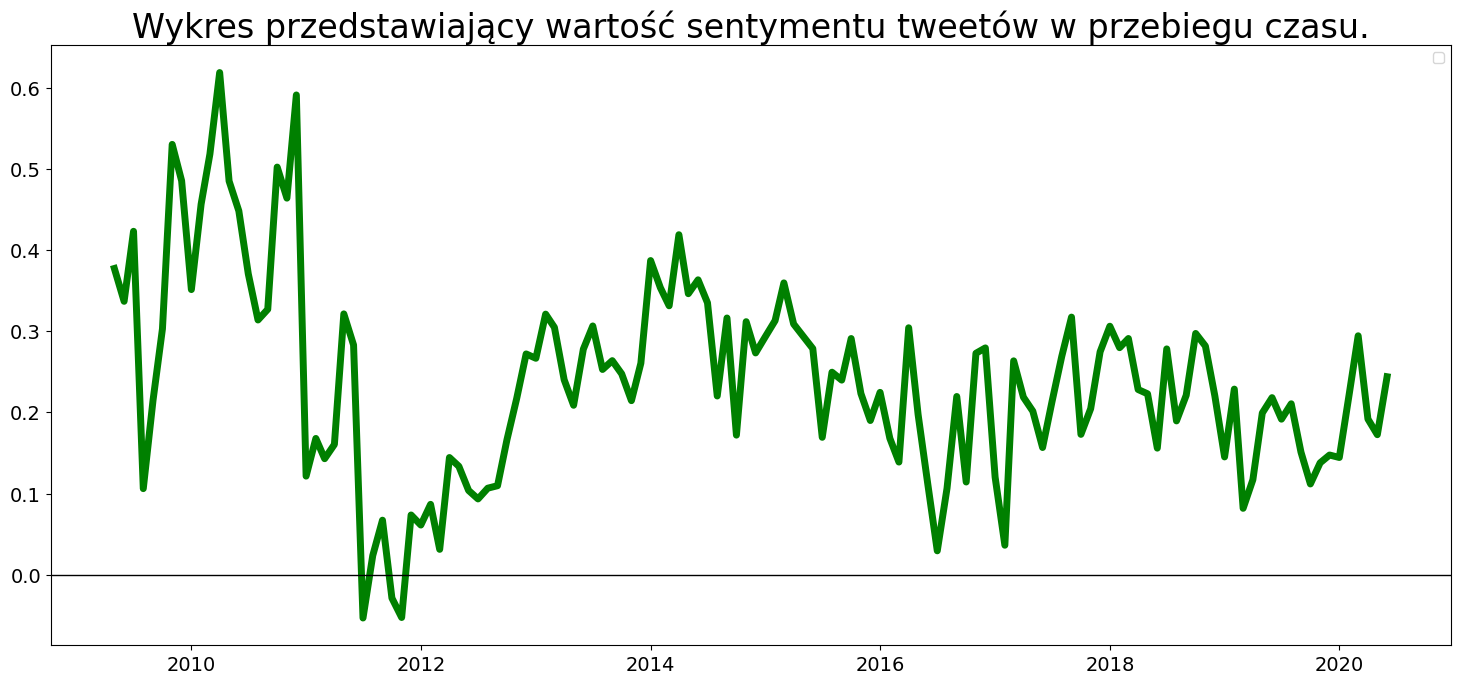

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["date"].apply(lambda x: x.year)

df["year_month"] = df["date"].apply(lambda x: str(x.year)+"-"+str(x.month))
df["year_month"] = pd.to_datetime(df["year_month"])
year_month = pd.pivot_table(df, values = "content", index = "year_month", aggfunc = "count")

fig = plt.figure(figsize = (14,6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Wykres przedstawiający wartość sentymentu tweetów w przebiegu czasu.", fontsize=24)
ax.tick_params(labelsize=14)

df["year_month"] = df["date"].apply(lambda x: str(x.year)+"-"+str(x.month))
df["year_month"] = pd.to_datetime(df["year_month"])
year_month = pd.pivot_table(df, values = "compound", index = "year_month", aggfunc = "mean")
ax.plot(year_month, lw = 5, color = "green")

ax.legend(["pos","neg"], fontsize=18)
plt.axhline(0, 0 ,1, color = "black", lw = 1)
plt.legend("")
plt.show()

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df[label])
vector = vectorizer.transform(df[label])
print(vector)

  (0, 24416)	0.21345777534731605
  (0, 23005)	0.28892188069081237
  (0, 22806)	0.1235925027453083
  (0, 22489)	0.24905550112013022
  (0, 22477)	0.20780175132638687
  (0, 22012)	0.34269110093265814
  (0, 21538)	0.24891961274043592
  (0, 17053)	0.3850989573103106
  (0, 14948)	0.21242262328662442
  (0, 12831)	0.30063114305312794
  (0, 12653)	0.30827434137947096
  (0, 12425)	0.2842591320665142
  (0, 6007)	0.1739875997809962
  (0, 4988)	0.2848943188914349
  (1, 23999)	0.33108451987216775
  (1, 22806)	0.13525474593943518
  (1, 22471)	0.25106854507503634
  (1, 22209)	0.22016335549212374
  (1, 14839)	0.1901078846895882
  (1, 14309)	0.26364914188506283
  (1, 12771)	0.19530511922388158
  (1, 6007)	0.1904051466089766
  (1, 5742)	0.3425379929877911
  (1, 3314)	0.29928482479942287
  (1, 3216)	0.27579622896279277
  :	:
  (43086, 22515)	0.24973840274513617
  (43086, 11631)	0.30107109495959367
  (43086, 9043)	0.2811065980998134
  (43086, 7459)	0.3426140526026585
  (43086, 7134)	0.28819568698873016
  (

In [ ]:
X = df['content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(vector,y,test_size = 0.2)

In [ ]:
logreg = LogisticRegression(max_iter = 1000)
model = logreg.fit(X_train, y_train)

In [ ]:
y_preds_training = model.predict(X_train)
y_preds_testing = model.predict(X_test)
accuracy_training = accuracy_score(y_train, y_preds_training)
accuracy_testing = accuracy_score(y_test, y_preds_testing)
print('Train data accuracy: ', accuracy_training*100, "%")
print('Test data accuracy: ', accuracy_testing*100, "%")
print("Confusion Matrix training : ")
print(confusion_matrix(y_train, y_preds_training))
print("Confusion Matrix testing : ")
print(confusion_matrix(y_test, y_preds_testing))
print("Classification report testing: ")
print(classification_report(y_test, y_preds_testing))
print("Classification report training : ")
print(classification_report(y_train, y_preds_training))

Train data accuracy:  94.14597354374565 %
Test data accuracy:  90.6949762153382 %
Confusion Matrix training : 
[[13479   724]
 [ 1294 18975]]
Confusion Matrix testing : 
[[3224  299]
 [ 503 4593]]
Classification report testing: 
              precision    recall  f1-score   support

         neg       0.87      0.92      0.89      3523
         pos       0.94      0.90      0.92      5096

    accuracy                           0.91      8619
   macro avg       0.90      0.91      0.90      8619
weighted avg       0.91      0.91      0.91      8619

Classification report training : 
              precision    recall  f1-score   support

         neg       0.91      0.95      0.93     14203
         pos       0.96      0.94      0.95     20269

    accuracy                           0.94     34472
   macro avg       0.94      0.94      0.94     34472
weighted avg       0.94      0.94      0.94     34472



In [26]:
res = vectorizer.transform(['obama should go hell', 'good morning'])
model.predict(res)

array(['neg', 'pos'], dtype=object)

In [ ]:
explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


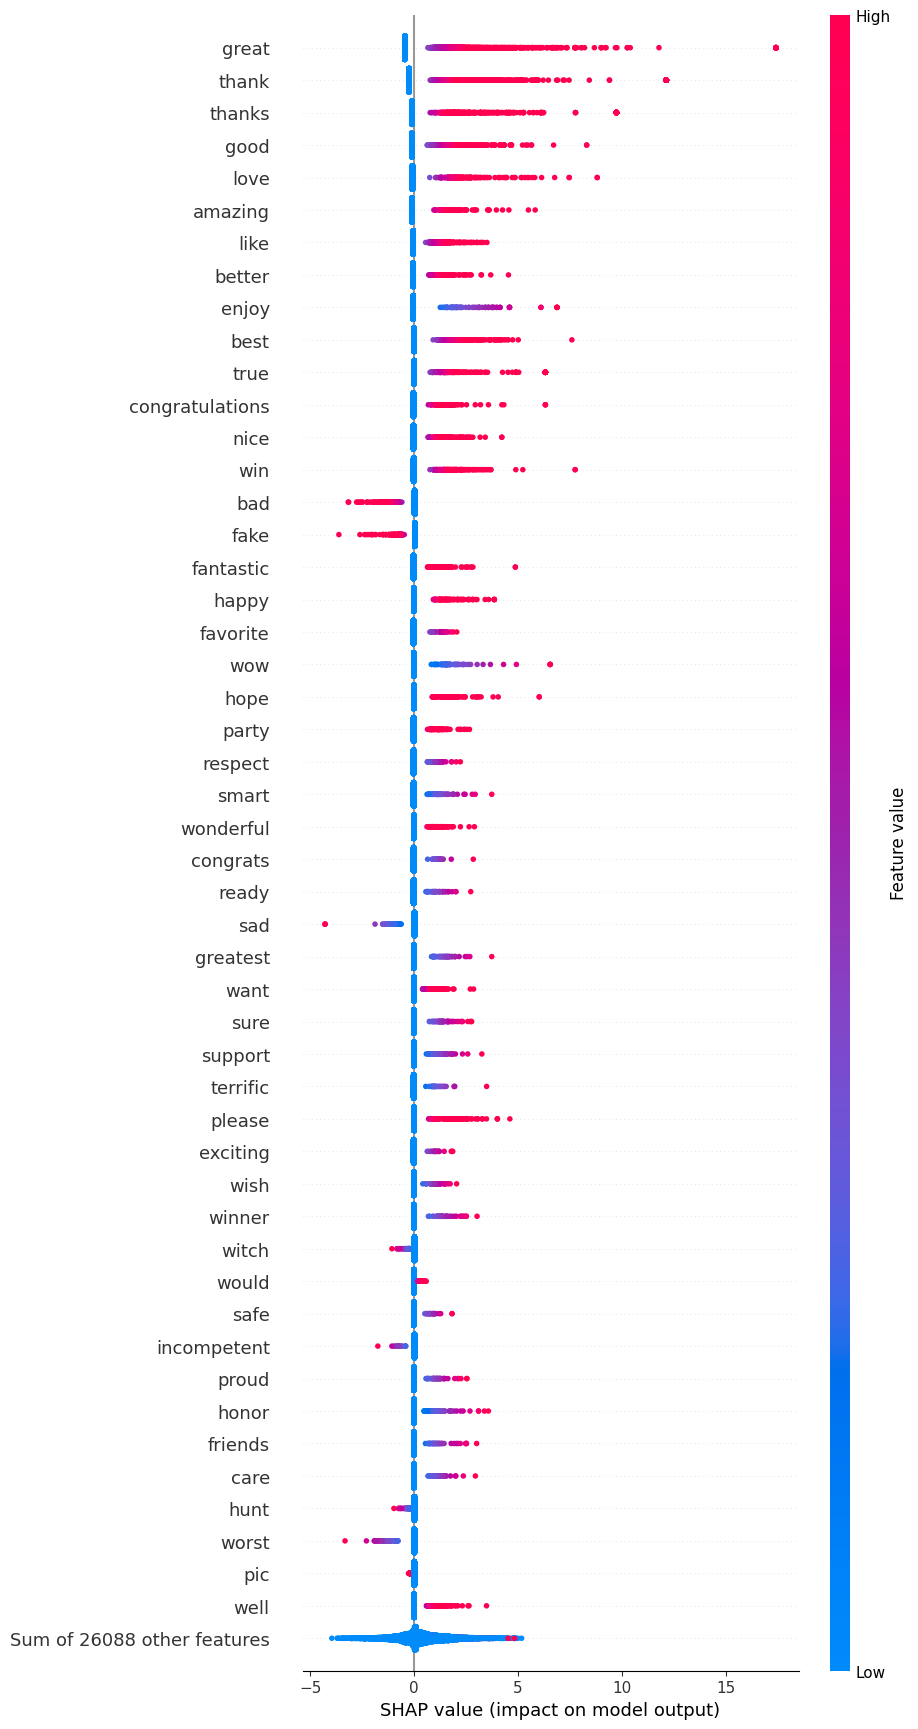

In [27]:
shap.plots.beeswarm(shap_values, max_display=50)